# Graph Attention Network Architecture

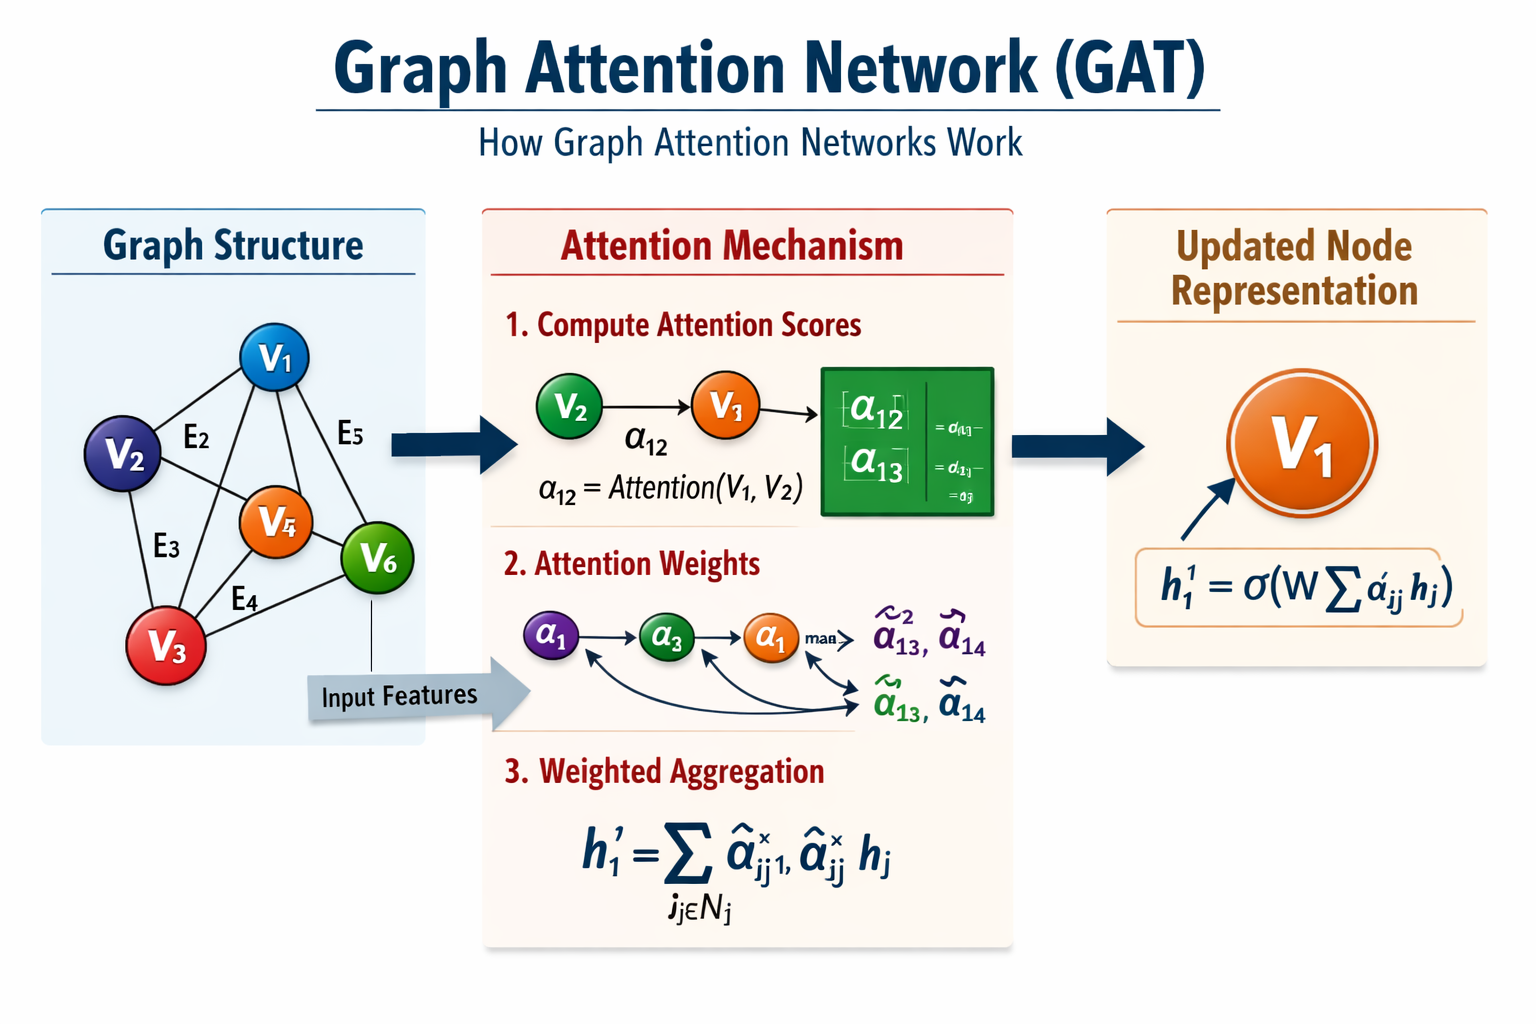

In ordinary Graph Neural Networks , all nodes are treated as equally inofrmative and eually important ! However , in attention Graph Networks , not all nodes contribute equally to update the neigbouring nodes ! Then  , as a result the importance representation of the nodes encapsulated as importanc score updates and contributes to the learning of the nodes rather than fixed weights! That is the reason it is called " Attention" network! 

Then , in this model , contrary to the ordinary Graph Neural Network , such as GraphSAGE , the network , learns which nodes to focus on as the most informative ones ! Then as such , if the graph represents a chemical molecule as drug , the "Attention"Graph Network , learns iteratively which atoms (functional groups) contribute primarily to the reactivity of the molecule , in terms of the chemical structure but not the steriochemical configuration in 3D space.Then a saturated carbon , the hydrogen atom may contribute less to the learning of the model compared to the oxygen in the carboxylic terminus of the molecule.

Then as a final key note , it is important to emphasize on the fact that in "Attention Graph Network" the model learns to "selectively" pay attention and focus and learn from most informative nodes! 

In the design of the Attention Graph Network , there are two sub-classes:

A) The Single-head Graph Attention Network where each node listens to other neighboring nodes in a single way ! For example , when this architecture is applied in drug design context , the single-headed model only captures one interaction pattern.

B) The Multi-headed Graph Attention Network in which each node of the graph learns from its neighbours in multiple ways "simultanously" which allows each node learn a different pattern of importance from its neighbours. As referring to the same xample above , this architecture learns simultanously from neighbouring atom a variety of represenation ! For example , it simultanously provides score on electronic effects , bond polarity , solubility and so on. This makes it more practical as each atom of the chemical molecule may contribute differently on each dimension of the interactivity in the environment.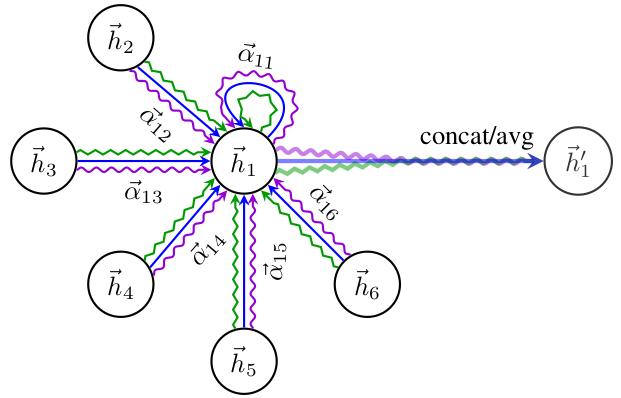

Eventually , care should be taken in order to confuse multi-headedness with the depth of the model as these two are two different model architectural context and each represents a different application to enrich the model. As multi-headedness increases the power of interpretation of each individual nodes from its neighbours , butthe depth of the model determines how far the aggragated information moves along the network.


# Mathematical Representation of the Single headed Graph Attention Network 

Imagine that the molecule is represented by N number of the atoms! Each atom will represent a distinct node (vertice) in the geometry of the represented graph and its chemical and physical numerical properties build an individual feature vector uniquely associated with that atom. The complete set of these feature vector of each atom form a set 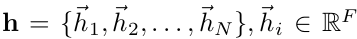in which F is the number of features per each atom.

However , this set of node features gets transformed in a new set 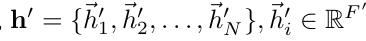based on the learning mechanism of the model!

In our model , each atom features needs to be "linearly" transformed before it gets into the model architect ! This transformation is done via a matrix , called weight matrix 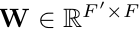! This linear transformation on each individaul atom`s feature forms the basis of the "model attntion score" which is simply the output of the function 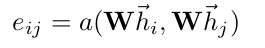 

As this model 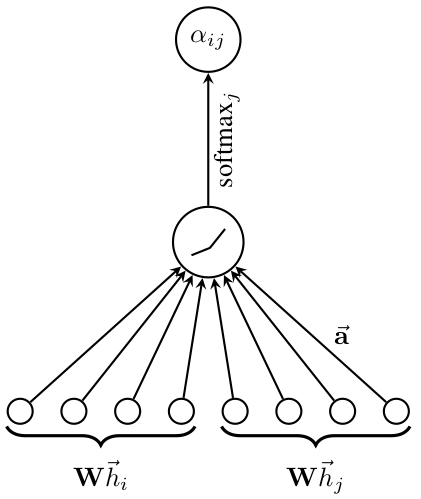 represents pictorially the weight matrix a is constructed as a learned weights parameters during training a forward model with inputs as the linearly transformed atom features.
The model adopted LeakyRelu as activation function andand Softmax function for normalization ti improve attention score interprebility across the whole graph and all neighbourhoods.

Finally , when all the attention scores are properly normalized , they are all invariantly summed up and non-linearly transformed in order to construct and capture the mostt complex structure is applied to the  the transformation of the feature vector of a given atom of a given molecule as an input. 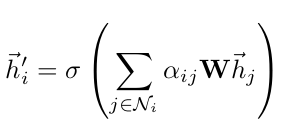

As an example , in the Graph Attention Network model architecture , the model based on the initial linear transformation by Matrix W is not able to distinguish the difference of the atom Oxygen in the carbony functional group over Oxygen in the carboxylic group , hence both represents different functionality and different reactivity. The final non-linear transformation on the sum of all features transformation improves the expressiveness of these fine differences in the structure of the molecule represented as a non-directed graph.

# Toy Model Construction using the Graph Attention Network 

In [78]:
!pip install torch-geometric rdkit-pypi   # Package RDKIT is used in order to represents SMILES into molecular graphs


2534.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [79]:
from torch_geometric.datasets import MoleculeNet  # As a reference to the Data https://pubs.rsc.org/en/content/articlepdf/2018/sc/c7sc02664a

In [80]:
# Load ESOL (solubility dataset)
dataset = MoleculeNet(root='data/MoleculeNet', name='ESOL')
print(f'Number of molecules: {len(dataset)}')
print(dataset[0])  # inspect firstThe very last molecule in the dataset ! As numbering starts from 0 , the last molecule will be 1127 
print(f'Number of features per atom: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')  

Number of molecules: 1128
Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Number of features per atom: 9
Number of classes: 734


/home/omid/miniconda3/envs/chemenv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:91: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  return self._infer_num_classes(self._data.y)


The code above shows that the last molecule in the ESOL dataset , has 32 atoms and each atoms has a vector of features of 9 elements!

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


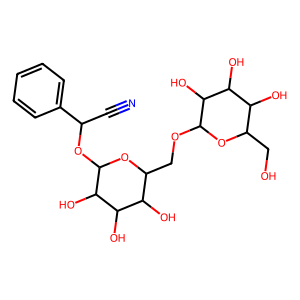

In [82]:
#Visualize as a chemical molecule (from SMILES)

from rdkit import Chem
from rdkit.Chem import Draw

smiles = dataset.smiles[0]     # By changing the index number here, you can visualize other molecules in the dataset from 0 to 1127 
mol = Chem.MolFromSmiles(smiles)

Draw.MolToImage(mol)

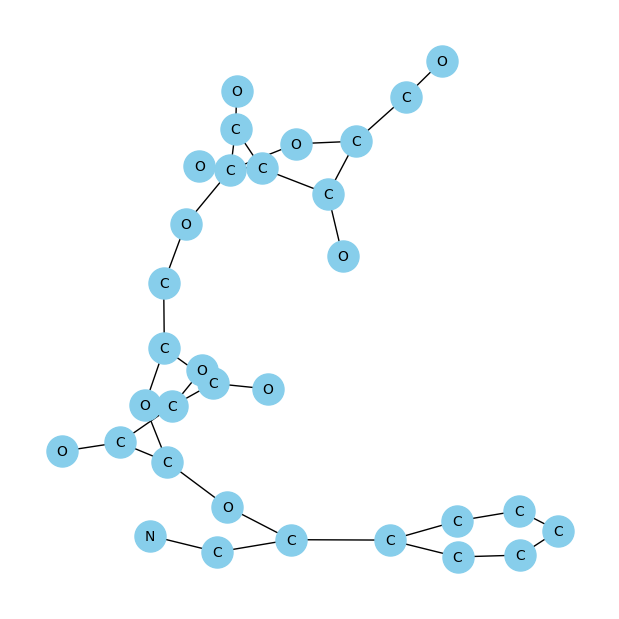

In [83]:
#Visualize as a graph (nodes = atoms, edges = bonds)

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from rdkit import Chem

data = dataset[0]
smiles = dataset.smiles[0]  # get SMILES
mol = Chem.MolFromSmiles(smiles)


atom_labels = [atom.GetSymbol() for atom in mol.GetAtoms()]


G = to_networkx(data, to_undirected=True)


plt.figure(figsize=(6,6))
pos = nx.spring_layout(G, seed=42)  # layout
nx.draw(
    G, pos,
    with_labels=True,
    labels=dict(zip(G.nodes(), atom_labels)),  # node number → atom symbol
    node_color='skyblue',
    node_size=500,
    font_size=10
)
plt.show()


# Valication between the Molecule and the Graph representation 

In [84]:
from rdkit import Chem
import torch

def validate_molecule_graph(data, smiles, verbose=True):
    """
    Validate that a PyG molecule graph matches the RDKit molecule.
    
    Args:
        data: PyG Data object
        smiles: SMILES string of the molecule
        verbose: print detailed comparison
    Returns:
        True if all checks pass, False otherwise
    """
    mol = Chem.MolFromSmiles(smiles)
    
    # 1Check number of atoms/nodes
    num_atoms = mol.GetNumAtoms()
    num_nodes = data.num_nodes
    if verbose:
        print(f"Atoms in molecule: {num_atoms}")
        print(f"Nodes in graph: {num_nodes}")
    if num_atoms != num_nodes:
        print("Mismatch in number of atoms/nodes!")
        return False

    # Check atom types
    atom_labels = [atom.GetSymbol() for atom in mol.GetAtoms()]
    if data.x is not None:
        # assume one-hot encoding
        predicted_atom_idx = data.x.argmax(dim=1).tolist()
        if verbose:
            print("Atom labels (RDKit):", atom_labels)
            print("Node features argmax:", predicted_atom_idx)
        # You may need mapping from one-hot index → atom symbol depending on dataset
    
    # Check number of bonds/edges
    num_bonds = mol.GetNumBonds()
    num_edges = data.edge_index.shape[1] // 2  # divide by 2 if undirected
    if verbose:
        print(f"Bonds in molecule: {num_bonds}")
        print(f"Edges in graph: {num_edges}")
    if num_bonds != num_edges:
        print("Mismatch in number of bonds/edges!")
        return False

    #  check bond types if edge_attr exists
    if hasattr(data, 'edge_attr') and data.edge_attr is not None:
        bond_types_rdkit = []
        for bond in mol.GetBonds():
            btype = str(bond.GetBondType())
            bond_types_rdkit.append(btype)
        if verbose:
            print("Bond types (RDKit):", bond_types_rdkit)
            print("Edge features shape:", data.edge_attr.shape)
            print("Note: mapping edge_attr to bond types depends on dataset encoding")

    if verbose:
        print("OK!  Molecule graph validation passed!")
    return True

# Example usage:
data = dataset[0]
smiles = dataset.smiles[0]
validate_molecule_graph(data, smiles)


Atoms in molecule: 32
Nodes in graph: 32
Atom labels (RDKit): ['O', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'O', 'C', 'O', 'C', 'O', 'C', 'O']
Node features argmax: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Bonds in molecule: 34
Edges in graph: 34
Bond types (RDKit): ['SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'TRIPLE', 'SINGLE', 'AROMATIC', 'AROMATIC', 'AROMATIC', 'AROMATIC', 'AROMATIC', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'SINGLE', 'AROMATIC', 'SINGLE', 'SINGLE']
Edge features shape: torch.Size([68, 3])
Note: mapping edge_attr to bond types depends on dataset encoding
OK!  Molecule graph validation passed!


True

# Exploratory data Analysis ( EDA) on ESOL Datasets from the MoleculeNet

In [11]:
import deepchem as dc
import pandas as pd

tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='Raw')
train, valid, test = datasets

df = pd.DataFrame({
    'smiles': train.ids,
    'logS': train.y.flatten()
})

df.head()


Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some PyTorch models, missing a dependency. No module named 'dgl'
No module named 'dgl'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


,smiles,logS
0,CC(C)=CCCC(C)=CC(=O),0.390413
1,CCCC=C,0.090421
2,CCCCCCCCCCCCCC,-2.464346
3,CC(C)Cl,0.704920
4,CCC(C)CO,1.159746


In [12]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  902 non-null    object 
 1   logS    902 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.2+ KB


smiles    0
logS      0
dtype: int64

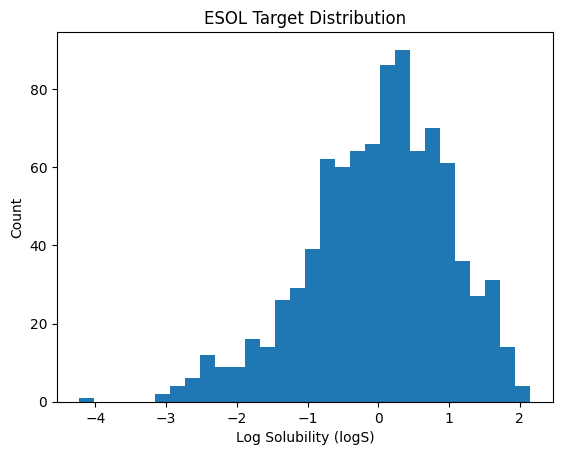

In [13]:
# Distribution of solubility (target EDA)

import matplotlib.pyplot as plt

plt.hist(df['logS'], bins=30)
plt.xlabel("Log Solubility (logS)")
plt.ylabel("Count")
plt.title("ESOL Target Distribution")
plt.show()

In [15]:
# Convert SMILES → RDKit molecules

from rdkit import Chem

df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df = df[df['mol'].notnull()]

In [16]:
# Molecular Descriptor Calculation

from rdkit.Chem import Descriptors

def compute_descriptors(mol):
    return {
        "MW": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "HBD": Descriptors.NumHDonors(mol),
        "HBA": Descriptors.NumHAcceptors(mol),
        "RotB": Descriptors.NumRotatableBonds(mol),
        "Rings": Descriptors.RingCount(mol)
    }

desc_df = df['mol'].apply(compute_descriptors).apply(pd.Series)
df = pd.concat([df, desc_df], axis=1)
df.head()


,smiles,logS,mol,MW,LogP,TPSA,HBD,HBA,RotB,Rings
0,CC(C)=CCCC(C)=CC(=O),0.390413,<rdkit.Chem.rdchem.Mol object at 0x7130ac0c9af0>,152.237,2.8780,17.07,0.0,1.0,4.0,0.0
1,CCCC=C,0.090421,<rdkit.Chem.rdchem.Mol object at 0x7130ac0c9b60>,70.135,1.9725,0.00,0.0,0.0,2.0,0.0
2,CCCCCCCCCCCCCC,-2.464346,<rdkit.Chem.rdchem.Mol object at 0x7130ac0c9bd0>,198.394,5.7074,0.00,0.0,0.0,11.0,0.0
3,CC(C)Cl,0.704920,<rdkit.Chem.rdchem.Mol object at 0x7130ac0c9c40>,78.542,1.6336,0.00,0.0,0.0,0.0,0.0
4,CCC(C)CO,1.159746,<rdkit.Chem.rdchem.Mol object at 0x7130ac0c9cb0>,88.150,1.0248,20.23,1.0,1.0,2.0,0.0


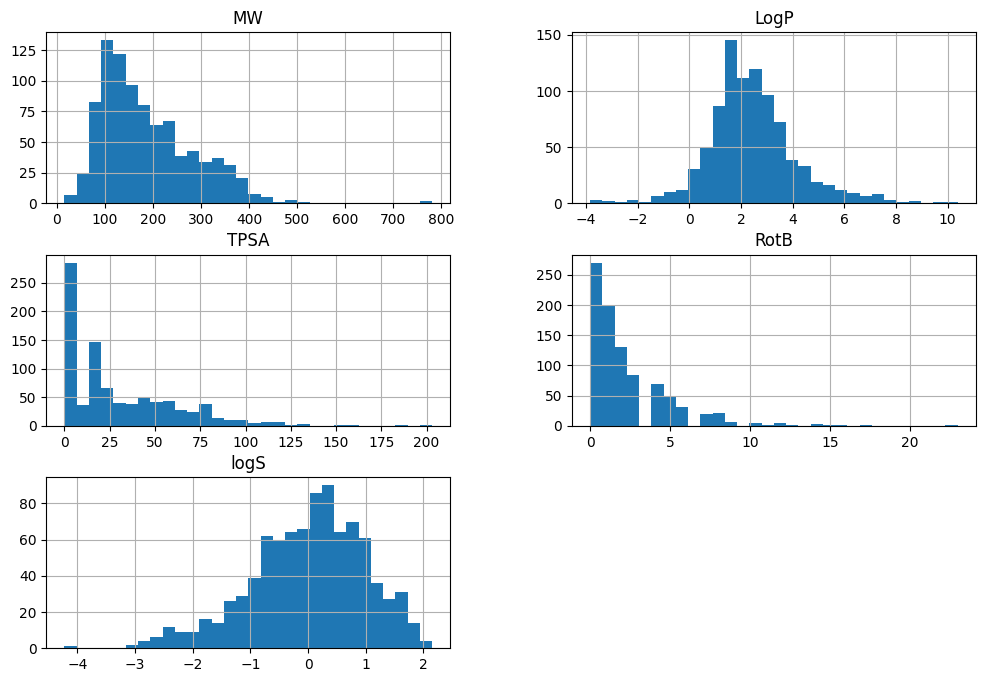

In [17]:
df[['MW','LogP','TPSA','RotB','logS']].hist(bins=30, figsize=(12,8))
plt.show()


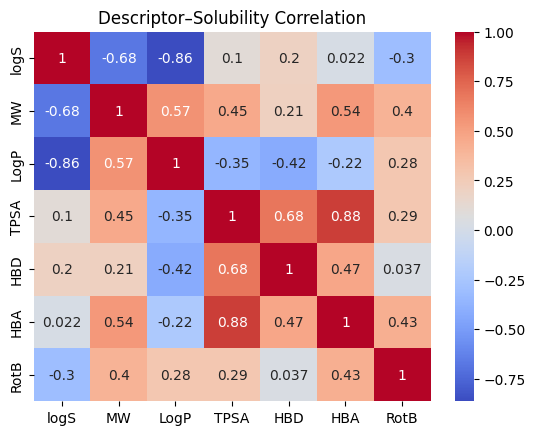

In [18]:
# Correlation Analysis

import seaborn as sns

corr = df[['logS','MW','LogP','TPSA','HBD','HBA','RotB']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Descriptor–Solubility Correlation")
plt.show()


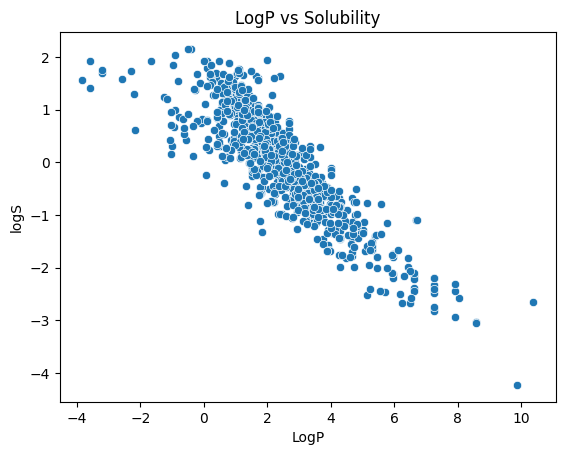

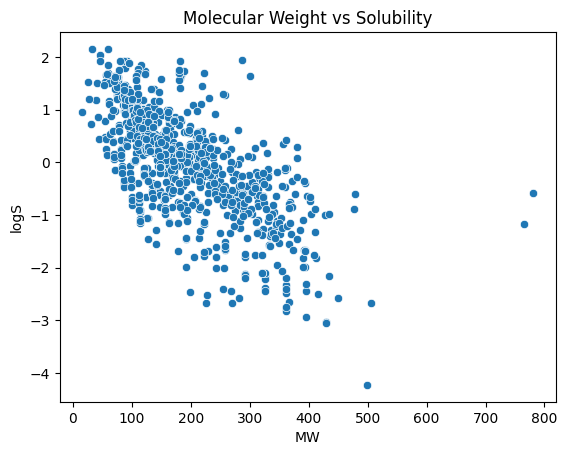

In [19]:
sns.scatterplot(x="LogP", y="logS", data=df)
plt.title("LogP vs Solubility")
plt.show()

sns.scatterplot(x="MW", y="logS", data=df)
plt.title("Molecular Weight vs Solubility")
plt.show()

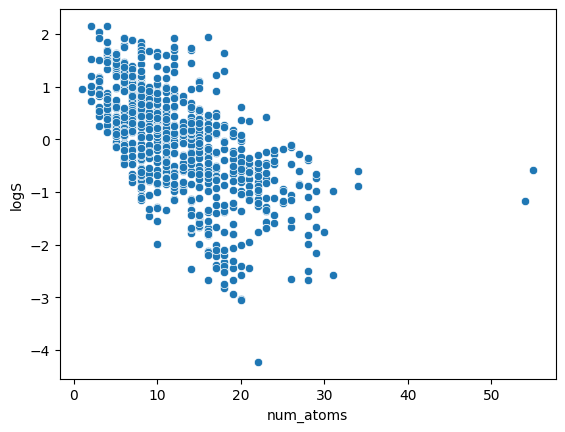

In [20]:
# Molecular Size Analysis

df['num_atoms'] = df['mol'].apply(lambda m: m.GetNumAtoms())

sns.scatterplot(x="num_atoms", y="logS", data=df)
plt.show()

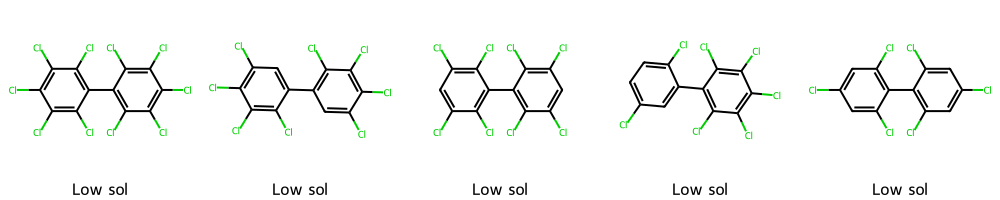

In [29]:
from rdkit.Chem import Draw

high_sol = df.sort_values("logS", ascending=False).head(5)['mol']
low_sol  = df.sort_values("logS").head(5)['mol']

Draw.MolsToGridImage(low_sol, molsPerRow=5, legends=["Low sol"]*5)

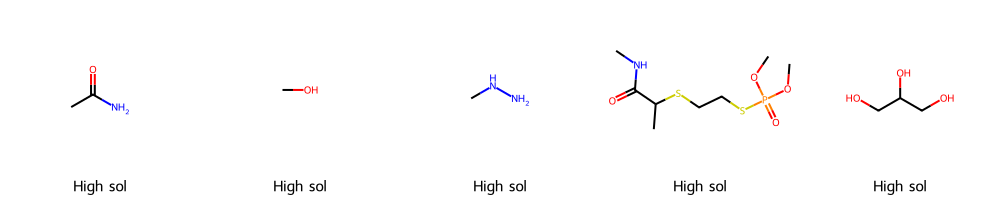

In [25]:
Draw.MolsToGridImage(high_sol, molsPerRow=5, legends=["High sol"]*5)

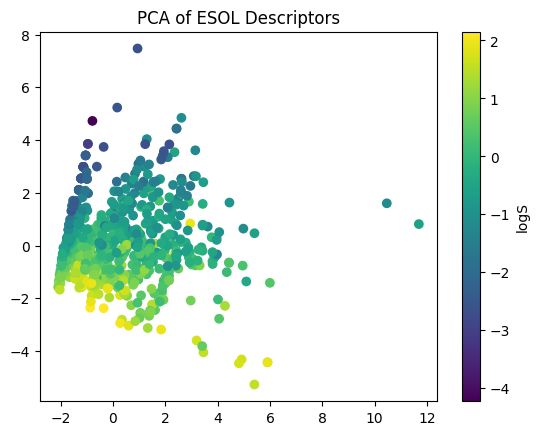

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df[['MW','LogP','TPSA','HBD','HBA','RotB']]
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=df['logS'], cmap='viridis')
plt.colorbar(label='logS')
plt.title("PCA of ESOL Descriptors")
plt.show()


#  Attention Visualization on Molecules

In [32]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data


In [33]:
from rdkit import Chem
import numpy as np

def atom_features(atom):
    return np.array([
        atom.GetAtomicNum(),
        atom.GetTotalDegree(),
        atom.GetFormalCharge(),
        atom.GetIsAromatic()
    ], dtype=float)


In [34]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    x = torch.tensor([atom_features(a) for a in mol.GetAtoms()],
                     dtype=torch.float)

    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index), mol


In [35]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.gat = GATConv(
            in_channels,
            32,
            heads=1,
            concat=False
        )
        self.lin = torch.nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x, (edge_idx, alpha) = self.gat(
            x, edge_index,
            return_attention_weights=True
        )
        x = F.elu(x)
        out = self.lin(x).mean(dim=0)
        return out, alpha, edge_idx


In [36]:
model = GAT(in_channels=4)
model.eval()


GAT(
  (gat): GATConv(4, 32, heads=1)
  (lin): Linear(in_features=32, out_features=1, bias=True)
)

In [39]:
smiles = "CCO"  # ethanol (high solubility)
data, mol = smiles_to_graph(smiles)

pred, alpha, edge_idx = model(data)


In [40]:
import numpy as np

num_atoms = mol.GetNumAtoms()
atom_attention = np.zeros(num_atoms)

for k, (src, dst) in enumerate(edge_idx.t().tolist()):
    atom_attention[dst] += alpha[k].item()

# Normalize
atom_attention /= atom_attention.max()


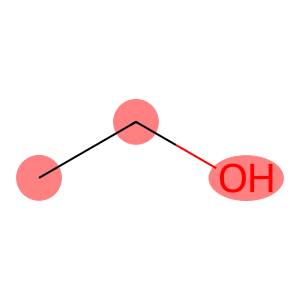

In [41]:
from rdkit.Chem import Draw

atom_colors = {
    i: (1.0, 1 - a, 1 - a)  # red = high attention
    for i, a in enumerate(atom_attention)
}

img = Draw.MolToImage(
    mol,
    size=(300, 300),
    highlightAtoms=list(atom_colors.keys()),
    highlightAtomColors=atom_colors
)

img


# Attention on ESOL 

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, DataLoader

import deepchem as dc
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [43]:
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='Raw')
train, valid, test = datasets


In [44]:
df_train = pd.DataFrame({'smiles': train.ids, 'logS': train.y.flatten()})
df_valid = pd.DataFrame({'smiles': valid.ids, 'logS': valid.y.flatten()})
df_test  = pd.DataFrame({'smiles': test.ids,  'logS': test.y.flatten()})


In [45]:
def atom_features(atom):
    return np.array([
        atom.GetAtomicNum(),
        atom.GetTotalDegree(),
        atom.GetFormalCharge(),
        atom.GetIsAromatic()
    ], dtype=float)


In [46]:
def smiles_to_graph(smiles, target=None):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None

    x = torch.tensor([atom_features(a) for a in mol.GetAtoms()], dtype=torch.float)
    
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    y = torch.tensor([target], dtype=torch.float) if target is not None else None
    data = Data(x=x, edge_index=edge_index, y=y)
    return data, mol


In [47]:
train_graphs = []
for idx, row in df_train.iterrows():
    g, mol = smiles_to_graph(row.smiles, row.logS)
    if g is not None:
        g.mol = mol
        train_graphs.append(g)
        
valid_graphs = []
for idx, row in df_valid.iterrows():
    g, mol = smiles_to_graph(row.smiles, row.logS)
    if g is not None:
        g.mol = mol
        valid_graphs.append(g)


In [48]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=32):
        super().__init__()
        self.gat = GATConv(in_channels, hidden_channels, heads=1, concat=False)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x, (edge_idx, alpha) = self.gat(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        out = self.lin(x).mean(dim=0)  # molecule-level prediction
        return out, alpha, edge_idx


In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(in_channels=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_graphs, batch_size=32)


In [50]:
for epoch in range(10):  # demo, can increase
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, _, _ = model(data)
        loss = criterion(out.view(-1), data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Train Loss: {total_loss/len(loader):.4f}")


Epoch 1 | Train Loss: 1.0006
Epoch 2 | Train Loss: 0.9944
Epoch 3 | Train Loss: 1.0138
Epoch 4 | Train Loss: 1.0360
Epoch 5 | Train Loss: 1.0048
Epoch 6 | Train Loss: 1.0346
Epoch 7 | Train Loss: 0.9952
Epoch 8 | Train Loss: 1.0086
Epoch 9 | Train Loss: 1.0216
Epoch 10 | Train Loss: 0.9820


In [51]:
high_sol = sorted(train_graphs, key=lambda x: x.y.item(), reverse=True)[:3]
low_sol  = sorted(train_graphs, key=lambda x: x.y.item())[:3]


In [52]:
def get_atom_attention(model, data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        _, alpha, edge_idx = model(data)
    
    num_atoms = data.num_nodes
    atom_attention = np.zeros(num_atoms)
    for k, (src, dst) in enumerate(edge_idx.t().tolist()):
        atom_attention[dst] += alpha[k].item()
    atom_attention /= atom_attention.max()
    return atom_attention


In [53]:
def plot_molecule_attention(mol, atom_attention):
    atom_colors = {i: (1.0, 1 - a, 1 - a) for i, a in enumerate(atom_attention)}
    img = Draw.MolToImage(
        mol,
        size=(300, 300),
        highlightAtoms=list(atom_colors.keys()),
        highlightAtomColors=atom_colors
    )
    return img


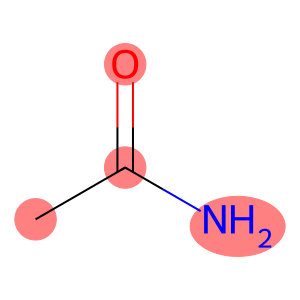

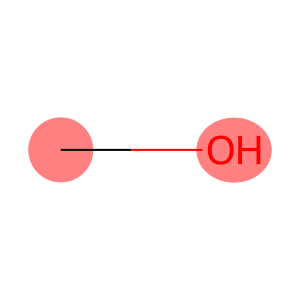

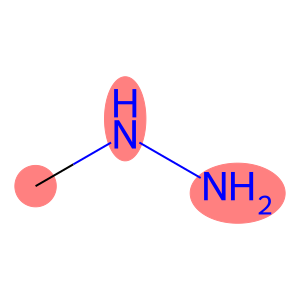

In [54]:
for g in high_sol:
    atom_att = get_atom_attention(model, g)
    img = plot_molecule_attention(g.mol, atom_att)
    display(img)


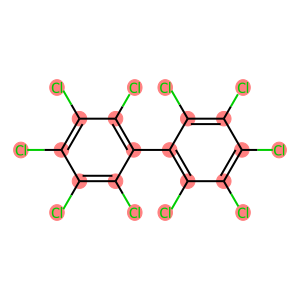

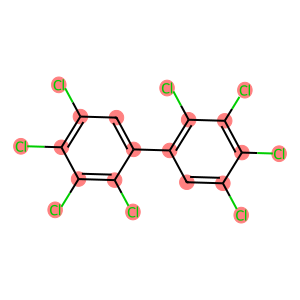

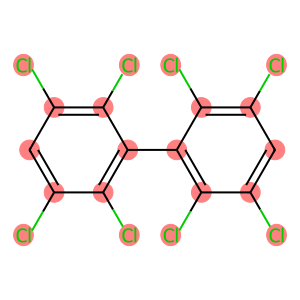

In [55]:
for g in low_sol:
    atom_att = get_atom_attention(model, g)
    img = plot_molecule_attention(g.mol, atom_att)
    display(img)


In [56]:
def bond_attention_img(mol, atom_attention):
    bond_colors = {}
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        score = max(atom_attention[i], atom_attention[j])
        bond_colors[bond.GetIdx()] = (1.0, 1 - score, 1 - score)
    
    img = Draw.MolToImage(
        mol,
        size=(300, 300),
        highlightBonds=list(bond_colors.keys()),
        highlightBondColors=bond_colors
    )
    return img


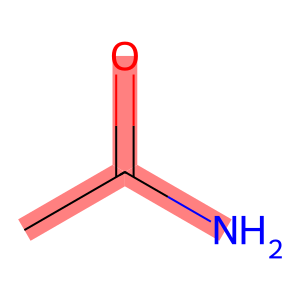

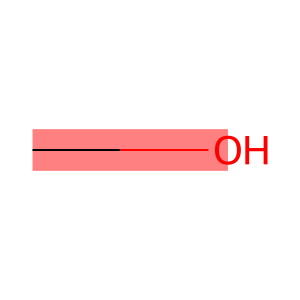

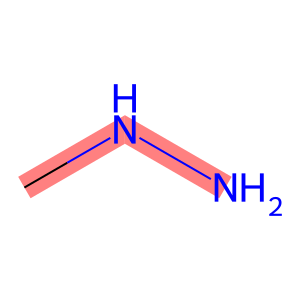

In [57]:
for g in high_sol:
    atom_att = get_atom_attention(model, g)
    img = bond_attention_img(g.mol, atom_att)
    display(img)


In [58]:
def highlight_aromatic_vs_polar(mol, atom_attention):
    atom_colors = {}
    for i, atom in enumerate(mol.GetAtoms()):
        if atom.GetIsAromatic():
            atom_colors[i] = (0.5, 0.5, 1.0)  # blue for aromatic
        elif atom.GetAtomicNum() in [7,8]:  # N or O
            atom_colors[i] = (1.0, 0.0, 0.0)  # red for polar
        else:
            # fade with attention
            a = atom_attention[i]
            atom_colors[i] = (1.0, 1 - a, 1 - a)
    img = Draw.MolToImage(
        mol,
        size=(300,300),
        highlightAtoms=list(atom_colors.keys()),
        highlightAtomColors=atom_colors
    )
    return img


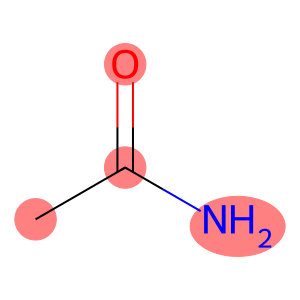

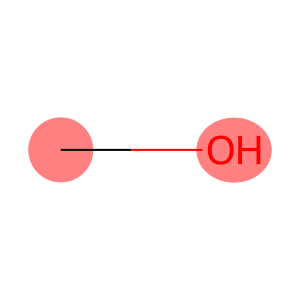

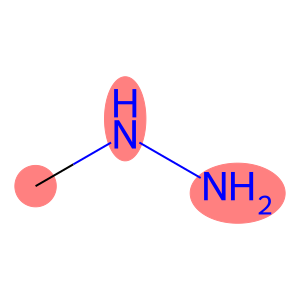

In [59]:
for g in high_sol:
    atom_att = get_atom_attention(model, g)
    img = highlight_aromatic_vs_polar(g.mol, atom_att)
    display(img)


# Simple Graph Attention Network Architecture Model 

In [ ]:
import deepchem as dc
import pandas as pd

tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='Raw')
train, valid, test = datasets

df_train = pd.DataFrame({'smiles': train.ids, 'logS': train.y.flatten()})
df_valid = pd.DataFrame({'smiles': valid.ids, 'logS': valid.y.flatten()})
df_test  = pd.DataFrame({'smiles': test.ids,  'logS': test.y.flatten()})


In [71]:
from rdkit import Chem
from torch_geometric.data import Data
import torch
import numpy as np

def atom_features(atom):                               #SMILES → PyTorch Geometric graph
    return np.array([
        atom.GetAtomicNum(),
        atom.GetTotalDegree(),
        atom.GetFormalCharge(),
        atom.GetIsAromatic()
    ], dtype=float)

def smiles_to_graph(smiles, target=None):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None

    x = torch.tensor([atom_features(a) for a in mol.GetAtoms()], dtype=torch.float)
    
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i,j])
        edge_index.append([j,i])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    y = torch.tensor([target], dtype=torch.float) if target is not None else None
    data = Data(x=x, edge_index=edge_index, y=y)
    return data, mol


In [72]:
train_graphs = [smiles_to_graph(row.smiles, row.logS)[0] for idx,row in df_train.iterrows() if smiles_to_graph(row.smiles,row.logS)[0] is not None]
valid_graphs = [smiles_to_graph(row.smiles, row.logS)[0] for idx,row in df_valid.iterrows() if smiles_to_graph(row.smiles,row.logS)[0] is not None]
test_graphs  = [smiles_to_graph(row.smiles, row.logS)[0] for idx,row in df_test.iterrows() if smiles_to_graph(row.smiles,row.logS)[0] is not None]


In [80]:
# Architecture of a simple shallow GAT model

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels=32):
        super().__init__()
        self.gat = GATConv(in_channels, hidden_channels, heads=1, concat=False)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x, (edge_idx, alpha) = self.gat(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        out = self.lin(x).mean(dim=0)  # molecule-level regression
        return out, alpha, edge_idx


In [81]:

# Optimization of the Model 

from torch_geometric.loader import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATModel(in_channels=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=32)


In [75]:
for epoch in range(20):  # demo, can increase to 50-100
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, _, _ = model(data)
        loss = criterion(out.view(-1), data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Train Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 | Train Loss: 1.0074
Epoch 2 | Train Loss: 1.0427
Epoch 3 | Train Loss: 1.0677
Epoch 4 | Train Loss: 1.0335
Epoch 5 | Train Loss: 1.0413
Epoch 6 | Train Loss: 1.0205
Epoch 7 | Train Loss: 1.0345
Epoch 8 | Train Loss: 1.0036
Epoch 9 | Train Loss: 1.0315
Epoch 10 | Train Loss: 0.9857
Epoch 11 | Train Loss: 1.0218
Epoch 12 | Train Loss: 1.0057
Epoch 13 | Train Loss: 1.0131
Epoch 14 | Train Loss: 1.0297
Epoch 15 | Train Loss: 1.0312
Epoch 16 | Train Loss: 1.0087
Epoch 17 | Train Loss: 1.0193
Epoch 18 | Train Loss: 0.9921
Epoch 19 | Train Loss: 0.9912
Epoch 20 | Train Loss: 0.9988


In [76]:
def get_atom_attention(model, data):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        _, alpha, edge_idx = model(data)
    num_atoms = data.num_nodes
    atom_attention = np.zeros(num_atoms)
    for k, (src,dst) in enumerate(edge_idx.t().tolist()):
        atom_attention[dst] += alpha[k].item()
    atom_attention /= atom_attention.max()
    return atom_attention


In [77]:
from rdkit.Chem import Draw

def plot_molecule_attention(mol, atom_attention):
    atom_colors = {i:(1.0, 1 - a, 1 - a) for i,a in enumerate(atom_attention)}
    img = Draw.MolToImage(mol, size=(300,300), highlightAtoms=list(atom_colors.keys()), highlightAtomColors=atom_colors)
    return img


In [79]:
model.eval()
with torch.no_grad():
    test_data = test_graphs[0].to(device)
    pred, _, _ = model(test_data)
print(f"Predicted logS: {pred.item():.4f}, True logS: {test_graphs[0].y.item():.4f}")


Predicted logS: -0.0566, True logS: -1.6011


# Traing Dataset , Validation set and Testing 

In [85]:
# Shuffle and split dataset into train/test (80/20)

from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader

torch.manual_seed(42)
dataset = dataset.shuffle()
train_dataset = dataset[:int(0.8*len(dataset))]
test_dataset  = dataset[int(0.8*len(dataset)):]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

/tmp/ipykernel_1955577/618360629.py:11: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
/tmp/ipykernel_1955577/618360629.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [86]:
from sklearn.model_selection import train_test_split
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.125, random_state=42)

In [87]:
train_dataset = [dataset[i] for i in train_indices]
val_dataset = [dataset[i] for i in val_indices]
test_dataset = [dataset[i] for i in test_indices]
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/tmp/ipykernel_1955577/1794249465.py:4: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
/tmp/ipykernel_1955577/1794249465.py:5: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
/tmp/ipykernel_1955577/1794249465.py:6: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Single-Headed Graph Attention Network in action 

In [1]:
# Install the necessary libraries if not already installed

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import MoleculeNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/home/omid/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set device
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


# Define the model for Single-Head Graph Attention Network from Scratch follwoing methodology above

In [3]:
class SingleHeadGATLayer(nn.Module):
    """True Single-Head Graph Attention Layer"""
    def __init__(self, in_features, out_features, dropout=0.2, alpha=0.2, concat=True):
        super(SingleHeadGATLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha
        self.concat = concat
        
        # Linear transformation for node features
        self.W = nn.Linear(in_features, out_features, bias=False)
        
        # Single attention vector (not multiple heads!)
        self.a = nn.Linear(2 * out_features, 1, bias=False)
        
        # LeakyReLU for attention
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        
        # Initialize parameters with better initialization
        self.reset_parameters()
    
    def reset_parameters(self):
        """Xavier initialization for better convergence"""
        nn.init.xavier_uniform_(self.W.weight, gain=1.414)  # Gain for ELU
        nn.init.xavier_uniform_(self.a.weight, gain=1.414)
    
    def forward(self, x, edge_index):
        """
        Forward pass of single-head GAT layer
        """
        # Convert input to float
        if x.dtype != torch.float32:
            x = x.float()
        
        num_nodes = x.size(0)
        
        # 1. Linear transformation: h = Wx
        h = self.W(x)
        
        # 2. Get source and target nodes
        src_nodes = edge_index[0]
        dst_nodes = edge_index[1]
        
        # 3. Gather features
        h_src = h[src_nodes]
        h_dst = h[dst_nodes]
        
        # 4. Concatenate and compute attention
        h_cat = torch.cat([h_src, h_dst], dim=1)
        attention_scores = self.leakyrelu(self.a(h_cat)).squeeze(1)
        
        # 5. Create attention matrix
        attention_matrix = torch.full(
            (num_nodes, num_nodes), 
            -1e9, 
            device=x.device, 
            dtype=attention_scores.dtype
        )
        attention_matrix[src_nodes, dst_nodes] = attention_scores
        
        # Apply softmax
        attention_weights = F.softmax(attention_matrix, dim=0)
        
        # 6. Apply dropout
        attention_weights = F.dropout(attention_weights, p=self.dropout, training=self.training)
        
        # 7. Mask to keep only actual edges
        edge_mask = torch.zeros((num_nodes, num_nodes), device=x.device, dtype=torch.bool)
        edge_mask[src_nodes, dst_nodes] = True
        attention_weights = attention_weights * edge_mask
        
        # 8. Aggregate neighbor features
        h_updated = torch.matmul(attention_weights, h)
        
        # 9. Apply activation
        if self.concat:
            return F.elu(h_updated)
        else:
            return h_updated

# Training Function Construction 

In [5]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    predictions = []
    targets = []
    
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    for batch in progress_bar:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Calculate loss
        loss = criterion(out, batch.y)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        optimizer.step()
        
        # Update metrics
        total_loss += loss.item() * batch.num_graphs
        predictions.extend(out.detach().cpu().numpy())
        targets.extend(batch.y.cpu().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({'Loss': loss.item()})

            # Calculate metrics
        avg_loss = total_loss / len(train_loader.dataset)
        predictions = np.array(predictions)
        targets = np.array(targets)
        r2 = r2_score(targets, predictions)
        mae = mean_absolute_error(targets, predictions)

    return avg_loss, r2, mae

In [6]:
def validate(model, loader, criterion, device, desc='Validation'):
    """Validate the model"""
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        progress_bar = tqdm(loader, desc=desc, leave=False)
        for batch in progress_bar:
            batch = batch.to(device)
            
            # Forward pass
            out = model(batch.x, batch.edge_index, batch.batch)
            
            # Calculate loss
            loss = criterion(out, batch.y)
            total_loss += loss.item() * batch.num_graphs
            
            # Store predictions
            predictions.extend(out.cpu().numpy())
            targets.extend(batch.y.cpu().numpy())
            
            progress_bar.set_postfix({'Loss': loss.item()})
    
    # Calculate metrics
    avg_loss = total_loss / len(loader.dataset)
    predictions = np.array(predictions)
    targets = np.array(targets)
    r2 = r2_score(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    
    return avg_loss, r2, mae, rmse, predictions, targets


# Complete training pipeline for SingleHeadGAT on ESOL

In [7]:
def train_full_gat_model():
    """Complete training pipeline for SingleHeadGAT on ESOL"""
    
    print("=" * 60)
    print("FULL SINGLE-HEAD GAT TRAINING ON ESOL DATASET")
    print("=" * 60)
    
    # 1. Load and Prepare Data
    print("\n1. Loading ESOL dataset...")
    dataset = MoleculeNet(root='./data/esol', name='ESOL')
    
    print(f"   Dataset loaded: {len(dataset)} molecules")
    print(f"   Number of node features: {dataset.num_features}")
    
    # Calculate statistics
    all_targets = [d.y.item() for d in dataset]
    print(f"   Target statistics:")
    print(f"     Min: {min(all_targets):.4f}")
    print(f"     Max: {max(all_targets):.4f}")
    print(f"     Mean: {np.mean(all_targets):.4f}")
    print(f"     Std: {np.std(all_targets):.4f}")
    
    # 2. Split Data (stratified by target values for better distribution)
    print("\n2. Splitting data into train/val/test...")
    
    # Create bins for stratification
    targets = np.array(all_targets)
    bins = np.linspace(targets.min(), targets.max(), 10)
    y_binned = np.digitize(targets, bins)
    
    indices = list(range(len(dataset)))
    train_idx, test_idx = train_test_split(
        indices, test_size=0.2, random_state=42, 
        stratify=y_binned, shuffle=True
    )
    
    # Get remaining indices for train/val split
    remaining_targets = [dataset[i].y.item() for i in train_idx]
    remaining_bins = np.digitize(remaining_targets, bins)
    
    train_idx, val_idx = train_test_split(
        train_idx, test_size=0.125, random_state=42,
        stratify=remaining_bins, shuffle=True
    )
    
    # Create datasets
    train_dataset = [dataset[i] for i in train_idx]
    val_dataset = [dataset[i] for i in val_idx]
    test_dataset = [dataset[i] for i in test_idx]
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    print(f"   Training samples: {len(train_idx)}")
    print(f"   Validation samples: {len(val_idx)}")
    print(f"   Test samples: {len(test_idx)}")
    
    # 3. Initialize Model
    print("\n3. Initializing SingleHeadGAT model...")
    model = SingleHeadGAT(
        in_channels=dataset.num_features,
        hidden_channels=128,
        out_channels=1,
        num_layers=3,
        dropout=0.2
    ).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    
    # 4. Training Setup
    print("\n4. Setting up training...")
    
    # Use L1 + L2 loss (Huber loss is more robust to outliers)
    criterion = nn.HuberLoss(delta=1.0)  # Combines L1 and L2
    
    # AdamW optimizer with better settings
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.001,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=1e-5
    )
    
    # Cosine annealing with warm restarts
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=50,  # Number of epochs for first restart
        T_mult=2,  # Multiplication factor for next restart
        eta_min=1e-6  # Minimum learning rate
    )
    
    # 5. Training Loop
    print("\n5. Starting training loop...")
    num_epochs = 300
    patience = 50  # Early stopping patience
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    
    # Tracking metrics
    train_losses, val_losses = [], []
    train_r2s, val_r2s = [], []
    train_maes, val_maes = [], []
    learning_rates = []
    
    for epoch in range(1, num_epochs + 1):
        # Train
        train_loss, train_r2, train_mae = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )
        
        # Validate
        val_loss, val_r2, val_mae, val_rmse, val_preds, val_targets = validate(
            model, val_loader, criterion, device, f'Validation (Epoch {epoch})'
        )
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_r2s.append(train_r2)
        val_r2s.append(val_r2)
        train_maes.append(train_mae)
        val_maes.append(val_mae)
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Learning rate scheduling
        scheduler.step()
        
        # Print epoch summary
        if epoch % 10 == 0 or epoch == 1:
            print(f"\nEpoch {epoch:03d}/{num_epochs}:")
            print(f"  Train - Loss: {train_loss:.4f}, R²: {train_r2:.4f}, MAE: {train_mae:.4f}")
            print(f"  Val   - Loss: {val_loss:.4f}, R²: {val_r2:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}")
            print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            best_epoch = epoch
            best_val_r2 = val_r2
            epochs_no_improve = 0
            
            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': best_val_loss,
                'val_r2': val_r2,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_r2s': train_r2s,
                'val_r2s': val_r2s,
            }, 'best_single_head_gat_full.pth')
            
            if epoch % 10 == 0:
                print(f"  ✓ New best model saved! Val Loss: {val_loss:.4f}")
        else:
            epochs_no_improve += 1
        
        # Early stopping
        if epochs_no_improve >= patience and epoch > 100:  # Wait at least 100 epochs
            print(f"\nEarly stopping triggered at epoch {epoch}")
            print(f"Best model was at epoch {best_epoch} with val loss {best_val_loss:.4f}")
            break
    
    # 6. Load Best Model
    print(f"\n6. Loading best model from epoch {best_epoch}...")
    model.load_state_dict(best_model_state)
    
    # 7. Plot Training History
    print("\n7. Plotting training history...")
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Loss plot
    axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2, alpha=0.8)
    axes[0, 0].plot(val_losses, label='Val Loss', linewidth=2, alpha=0.8)
    axes[0, 0].axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label='Best Model')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # R² plot
    axes[0, 1].plot(train_r2s, label='Train R²', linewidth=2, alpha=0.8)
    axes[0, 1].plot(val_r2s, label='Val R²', linewidth=2, alpha=0.8)
    axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[0, 1].axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label='Best Model')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('R² Score')
    axes[0, 1].set_title('R² Score (Higher is better)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # MAE plot
    axes[0, 2].plot(train_maes, label='Train MAE', linewidth=2, alpha=0.8)
    axes[0, 2].plot(val_maes, label='Val MAE', linewidth=2, alpha=0.8)
    axes[0, 2].axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label='Best Model')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('MAE')
    axes[0, 2].set_title('Mean Absolute Error (Lower is better)')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Learning rate plot
    axes[1, 0].plot(learning_rates, linewidth=2, color='purple')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')
    
    # Validation predictions vs true
    axes[1, 1].scatter(val_targets, val_preds, alpha=0.6, s=30, c='blue')
    min_val = min(val_targets.min(), val_preds.min())
    max_val = max(val_targets.max(), val_preds.max())
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect', linewidth=2)
    axes[1, 1].set_xlabel('True Solubility (log mol/L)')
    axes[1, 1].set_ylabel('Predicted Solubility (log mol/L)')
    axes[1, 1].set_title(f'Validation Predictions\nR² = {best_val_r2:.3f}')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Error distribution
    errors = val_preds - val_targets
    axes[1, 2].hist(errors, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 2].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[1, 2].set_xlabel('Prediction Error')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title(f'Error Distribution\nMean: {errors.mean():.3f}, Std: {errors.std():.3f}')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('full_training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 8. Test Evaluation
    print("\n8. Evaluating on test set...")
    test_loss, test_r2, test_mae, test_rmse, test_preds, test_targets = validate(
        model, test_loader, criterion, device, 'Test Set'
    )
    
    print(f"\n" + "="*60)
    print("FINAL TEST SET RESULTS:")
    print("="*60)
    print(f"  Loss: {test_loss:.4f}")
    print(f"  R² Score: {test_r2:.4f}")
    print(f"  MAE: {test_mae:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  Standard Deviation of Errors: {np.std(test_preds - test_targets):.4f}")
    
    # Plot test predictions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot
    scatter = ax1.scatter(test_targets, test_preds, alpha=0.7, s=50, 
                          c=np.abs(test_preds - test_targets), 
                          cmap='viridis', vmin=0, vmax=3)
    min_val = min(test_targets.min(), test_preds.min())
    max_val = max(test_targets.max(), test_preds.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3, label='Perfect Prediction')
    ax1.set_xlabel('True Solubility (log mol/L)', fontsize=12)
    ax1.set_ylabel('Predicted Solubility (log mol/L)', fontsize=12)
    ax1.set_title(f'Test Set Predictions\nSingle-Head GAT (R²={test_r2:.3f}, MAE={test_mae:.3f})', 
                  fontsize=14)
    plt.colorbar(scatter, ax=ax1, label='Absolute Error')
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Error plot
    sorted_indices = np.argsort(test_targets)
    sorted_targets = test_targets[sorted_indices]
    sorted_preds = test_preds[sorted_indices]
    errors = sorted_preds - sorted_targets
    
    ax2.plot(sorted_targets, errors, 'o-', alpha=0.6, markersize=4, linewidth=1)
    ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax2.fill_between(sorted_targets, errors - np.std(errors), 
                     errors + np.std(errors), alpha=0.2, color='blue')
    ax2.set_xlabel('True Solubility (log mol/L)', fontsize=12)
    ax2.set_ylabel('Prediction Error', fontsize=12)
    ax2.set_title('Prediction Errors vs True Values', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('test_predictions_full.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 9. Save Final Model
    print("\n9. Saving final model...")
    final_model_path = 'single_head_gat_final_trained.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'in_channels': dataset.num_features,
            'hidden_channels': 128,
            'num_layers': 3,
            'dropout': 0.2
        },
        'test_metrics': {
            'r2': test_r2,
            'mae': test_mae,
            'rmse': test_rmse,
            'mse': test_loss
        },
        'train_metrics': {
            'best_epoch': best_epoch,
            'best_val_loss': best_val_loss,
            'best_val_r2': best_val_r2,
            'final_train_loss': train_losses[-1],
            'final_val_loss': val_losses[-1]
        },
        'data_info': {
            'train_size': len(train_dataset),
            'val_size': len(val_dataset),
            'test_size': len(test_dataset),
            'feature_dim': dataset.num_features
        }
    }, final_model_path)
    
    print(f"   Model saved to: {final_model_path}")
    
    # 10. Make sample predictions
    print("\n" + "="*60)
    print("SAMPLE PREDICTIONS")
    print("="*60)
    
    model.eval()
    sample_indices = np.random.choice(len(test_dataset), min(5, len(test_dataset)), replace=False)
    
    for i, idx in enumerate(sample_indices):
        data = test_dataset[idx]
        data = data.to(device)
        batch = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
        
        with torch.no_grad():
            prediction = model(data.x, data.edge_index, batch)
            
            print(f"\nSample {i+1}:")
            print(f"  True solubility: {data.y.item():.4f} log mol/L")
            print(f"  Prediction: {prediction.item():.4f} log mol/L")
            print(f"  Error: {abs(prediction.item() - data.y.item()):.4f}")
            print(f"  % Error: {abs(prediction.item() - data.y.item()) / abs(data.y.item()) * 100:.1f}%")
    
    return model, test_r2, test_mae

#  Load and Predict Function

In [8]:
def load_and_predict(model_path='single_head_gat_final_trained.pth'):
    """Load trained model and make predictions"""
    
    print("=" * 60)
    print("LOADING TRAINED MODEL FOR PREDICTIONS")
    print("=" * 60)
    
    # Load the model checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Load dataset to get feature dimension
    dataset = MoleculeNet(root='./data/esol', name='ESOL')
    
    # Create model with same configuration
    config = checkpoint['model_config']
    model = SingleHeadGAT(
        in_channels=config['in_channels'],
        hidden_channels=config['hidden_channels'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    ).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print("Model loaded successfully!")
    print(f"\nModel Configuration:")
    print(f"  Input features: {config['in_channels']}")
    print(f"  Hidden size: {config['hidden_channels']}")
    print(f"  Layers: {config['num_layers']}")
    print(f"  Dropout: {config['dropout']}")
    
    print(f"\nTest Performance from training:")
    metrics = checkpoint['test_metrics']
    print(f"  R² Score: {metrics['r2']:.4f}")
    print(f"  MAE: {metrics['mae']:.4f}")
    print(f"  RMSE: {metrics['rmse']:.4f}")
    
    # Make predictions on new data
    print(f"\nMaking predictions on sample molecules from test set...")
    
    # Get test dataset
    _, test_idx = train_test_split(
        list(range(len(dataset))), test_size=0.2, random_state=42
    )
    test_dataset = [dataset[i] for i in test_idx[:10]]  # First 10 test molecules
    
    for i, data in enumerate(test_dataset):
        data = data.to(device)
        batch = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
        
        with torch.no_grad():
            prediction = model(data.x, data.edge_index, batch)
            
            print(f"\nMolecule {i+1}:")
            print(f"  True: {data.y.item():.4f} log mol/L")
            print(f"  Pred: {prediction.item():.4f} log mol/L")
            print(f"  Error: {abs(prediction.item() - data.y.item()):.4f}")
    
    return model

# Main Execution

In [9]:

if __name__ == "__main__":
    print("=" * 60)
    print("FULL SINGLE-HEAD GAT TRAINING PIPELINE")
    print("=" * 60)
    
    print("\nOptions:")
    print("1. Train a new model from scratch")
    print("2. Load existing model and make predictions")
    
    choice = input("\nEnter your choice (1 or 2): ").strip()
    
    if choice == '1':
        print("\n" + "="*60)
        print("STARTING FULL TRAINING")
        print("="*60)
        
        try:
            model, test_r2, test_mae = train_full_gat_model()
            print(f"\n" + "="*60)
            print(f"TRAINING COMPLETED SUCCESSFULLY!")
            print(f"Final Test R²: {test_r2:.4f}")
            print(f"Final Test MAE: {test_mae:.4f}")
            print("="*60)
            
        except Exception as e:
            print(f"\nError during training: {e}")
            import traceback
            traceback.print_exc()
    
    elif choice == '2':
        print("\n" + "="*60)
        print("LOADING EXISTING MODEL")
        print("="*60)
        
        try:
            model = load_and_predict()
            print(f"\n" + "="*60)
            print("PREDICTIONS COMPLETED")
            print("="*60)
            
        except FileNotFoundError:
            print("\nModel file not found. Please train a model first.")
            print("Falling back to training a new model...")
            
            try:
                model, test_r2, test_mae = train_full_gat_model()
                print(f"\nTraining completed! Test R²: {test_r2:.4f}")
            except Exception as e:
                print(f"Training failed: {e}")
    
    else:
        print("\nInvalid choice. Please enter 1 or 2.")

FULL SINGLE-HEAD GAT TRAINING PIPELINE

Options:
1. Train a new model from scratch
2. Load existing model and make predictions

LOADING EXISTING MODEL
LOADING TRAINED MODEL FOR PREDICTIONS

Model file not found. Please train a model first.
Falling back to training a new model...
FULL SINGLE-HEAD GAT TRAINING ON ESOL DATASET

1. Loading ESOL dataset...
   Dataset loaded: 1128 molecules
   Number of node features: 9
   Target statistics:
     Min: -11.6000
     Max: 1.5800
     Mean: -3.0501
     Std: 2.0955

2. Splitting data into train/val/test...
Training failed: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.


Using device: cpu
SINGLE-HEAD GAT: TRAIN OR PREDICT

Options:
1. Train a new model (20 epochs)
2. Load existing model and make predictions

LOADING MODEL
LOADING TRAINED MODEL
Model file 'single_head_gat_quick.pth' not found.
Training a new model first...

QUICK TRAINING (20 EPOCHS)
Dataset: 1128 molecules
Features: 9
Train: 789, Val: 113, Test: 226

Model parameters: 7,809
Epoch  5: Train Loss = 4.8024, Val Loss = 3.5428, Val R² = 0.0228
Epoch 10: Train Loss = 4.7550, Val Loss = 3.5504, Val R² = 0.0337
Epoch 15: Train Loss = 4.6899, Val Loss = 3.5863, Val R² = 0.0117
Epoch 20: Train Loss = 4.6479, Val Loss = 3.5394, Val R² = 0.0392

Test Results:
  R² Score: 0.0201
  MAE: 1.7038
  RMSE: 2.1522

Model saved to: single_head_gat_quick.pth


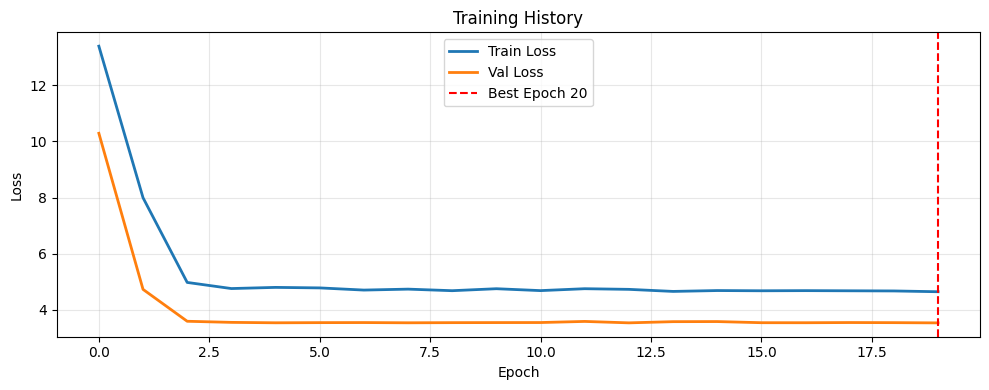

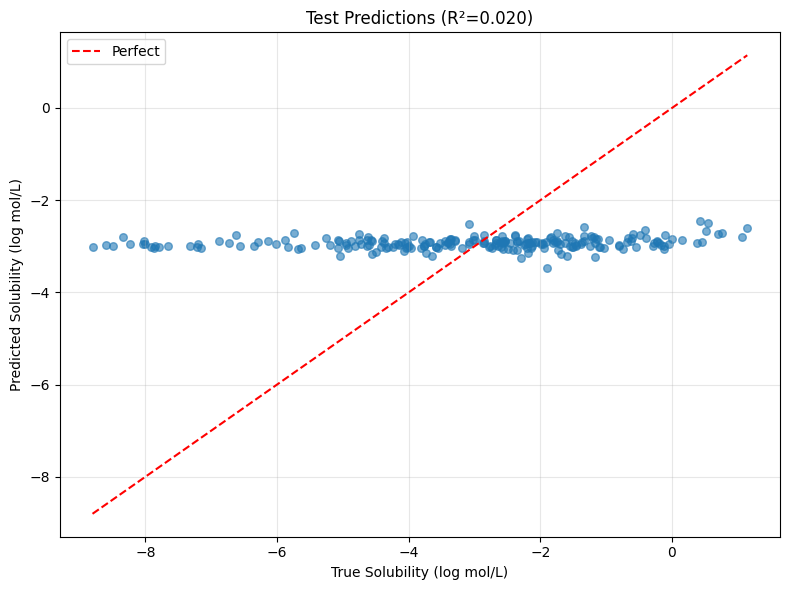


PREDICTIONS COMPLETED

PROGRAM COMPLETED


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import MoleculeNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# 1. SingleHeadGATLayer (simplified)
# ============================================================================

class SingleHeadGATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.2, alpha=0.2, concat=True):
        super(SingleHeadGATLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha
        self.concat = concat
        
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a = nn.Linear(2 * out_features, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        
        # Initialize parameters
        nn.init.xavier_uniform_(self.W.weight)
        nn.init.xavier_uniform_(self.a.weight)
    
    def forward(self, x, edge_index):
        if x.dtype != torch.float32:
            x = x.float()
        
        num_nodes = x.size(0)
        h = self.W(x)
        
        src_nodes = edge_index[0]
        dst_nodes = edge_index[1]
        
        h_src = h[src_nodes]
        h_dst = h[dst_nodes]
        h_cat = torch.cat([h_src, h_dst], dim=1)
        
        attention_scores = self.leakyrelu(self.a(h_cat)).squeeze(1)
        
        attention_matrix = torch.full(
            (num_nodes, num_nodes), 
            -1e9, 
            device=x.device, 
            dtype=attention_scores.dtype
        )
        attention_matrix[src_nodes, dst_nodes] = attention_scores
        
        attention_weights = F.softmax(attention_matrix, dim=0)
        attention_weights = F.dropout(attention_weights, p=self.dropout, training=self.training)
        
        edge_mask = torch.zeros((num_nodes, num_nodes), device=x.device, dtype=torch.bool)
        edge_mask[src_nodes, dst_nodes] = True
        attention_weights = attention_weights * edge_mask
        
        h_updated = torch.matmul(attention_weights, h)
        
        if self.concat:
            return F.elu(h_updated)
        else:
            return h_updated

# ============================================================================
# 2. SingleHeadGAT Model
# ============================================================================

class SingleHeadGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels=128, out_channels=1, 
                 num_layers=3, dropout=0.2):
        super(SingleHeadGAT, self).__init__()
        
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Create GAT layers
        self.gat_layers = nn.ModuleList()
        
        # First layer
        self.gat_layers.append(
            SingleHeadGATLayer(in_channels, hidden_channels, dropout=dropout, concat=True)
        )
        
        # Intermediate layers
        for i in range(1, num_layers - 1):
            self.gat_layers.append(
                SingleHeadGATLayer(hidden_channels, hidden_channels, dropout=dropout, concat=True)
            )
        
        # Final layer
        self.gat_layers.append(
            SingleHeadGATLayer(hidden_channels, hidden_channels, dropout=dropout, concat=False)
        )
        
        # Batch normalization
        self.batch_norms = nn.ModuleList()
        for i in range(num_layers):
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))
        
        # Readout layers
        self.readout = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels // 2, hidden_channels // 4),
            nn.ReLU(),
            nn.Dropout(dropout // 2),
            nn.Linear(hidden_channels // 4, out_channels)
        )
        
    def forward(self, x, edge_index, batch):
        if x.dtype != torch.float32:
            x = x.float()
        
        for i, (gat_layer, batch_norm) in enumerate(zip(self.gat_layers, self.batch_norms)):
            if i > 0:
                residual = x
            
            x = gat_layer(x, edge_index)
            x = batch_norm(x)
            
            if i < len(self.gat_layers) - 1:
                x = F.relu(x)
            
            x = F.dropout(x, p=self.dropout, training=self.training)
            
            if i > 0:
                x = x + residual
        
        x = global_mean_pool(x, batch)
        x = self.readout(x)
        
        return x.squeeze(-1)

# ============================================================================
# 3. Quick Training Function
# ============================================================================

def quick_train():
    """Quick training to create a model"""
    print("\n" + "="*60)
    print("QUICK TRAINING (20 EPOCHS)")
    print("="*60)
    
    # Load data
    dataset = MoleculeNet(root='./data/esol', name='ESOL')
    print(f"Dataset: {len(dataset)} molecules")
    print(f"Features: {dataset.num_features}")
    
    # Simple split without stratification
    indices = list(range(len(dataset)))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.125, random_state=42)
    
    train_dataset = [dataset[i] for i in train_idx]
    val_dataset = [dataset[i] for i in val_idx]
    test_dataset = [dataset[i] for i in test_idx]
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
    
    # Create model
    model = SingleHeadGAT(
        in_channels=dataset.num_features,
        hidden_channels=64,  # Smaller for quick training
        out_channels=1,
        num_layers=2,  # Simpler
        dropout=0.2
    ).to(device)
    
    print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Training setup
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Train for 20 epochs
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    
    for epoch in range(1, 21):
        # Train
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            output = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(output, batch.y)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch.num_graphs
        
        avg_train_loss = train_loss / len(train_dataset)
        train_losses.append(avg_train_loss)
        
        # Validate
        model.eval()
        val_loss = 0
        val_preds, val_targets = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch.x, batch.edge_index, batch.batch)
                loss = criterion(output, batch.y)
                val_loss += loss.item() * batch.num_graphs
                val_preds.extend(output.cpu().numpy())
                val_targets.extend(batch.y.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_dataset)
        val_losses.append(avg_val_loss)
        val_r2 = r2_score(val_targets, val_preds)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            best_epoch = epoch
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch:2d}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val R² = {val_r2:.4f}")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Test
    model.eval()
    test_preds, test_targets = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch.x, batch.edge_index, batch.batch)
            test_preds.extend(output.cpu().numpy())
            test_targets.extend(batch.y.cpu().numpy())
    
    test_r2 = r2_score(test_targets, test_preds)
    test_mae = mean_absolute_error(test_targets, test_preds)
    test_rmse = np.sqrt(mean_squared_error(test_targets, test_preds))
    
    print(f"\nTest Results:")
    print(f"  R² Score: {test_r2:.4f}")
    print(f"  MAE: {test_mae:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    
    # Save model
    model_path = 'single_head_gat_quick.pth'
    torch.save({
        'epoch': best_epoch,
        'model_state_dict': model.state_dict(),
        'model_config': {
            'in_channels': dataset.num_features,
            'hidden_channels': 64,
            'num_layers': 2,
            'dropout': 0.2
        },
        'test_metrics': {
            'r2': test_r2,
            'mae': test_mae,
            'rmse': test_rmse
        }
    }, model_path)
    
    print(f"\nModel saved to: {model_path}")
    
    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Val Loss', linewidth=2)
    plt.axvline(x=best_epoch-1, color='r', linestyle='--', label=f'Best Epoch {best_epoch}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('quick_training_history.png', dpi=100)
    plt.show()
    
    # Plot predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(test_targets, test_preds, alpha=0.6, s=30)
    min_val = min(min(test_targets), min(test_preds))
    max_val = max(max(test_targets), max(test_preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect')
    plt.xlabel('True Solubility (log mol/L)')
    plt.ylabel('Predicted Solubility (log mol/L)')
    plt.title(f'Test Predictions (R²={test_r2:.3f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('quick_test_predictions.png', dpi=100)
    plt.show()
    
    return model, test_r2

# ============================================================================
# 4. Load and Predict Function (Simplified)
# ============================================================================

def load_and_predict_simple(model_path='single_head_gat_quick.pth'):
    """Load trained model and make predictions"""
    
    print("=" * 60)
    print("LOADING TRAINED MODEL")
    print("=" * 60)
    
    # Check if model exists
    if not os.path.exists(model_path):
        print(f"Model file '{model_path}' not found.")
        print("Training a new model first...")
        model, _ = quick_train()
        return model
    
    # Load model
    checkpoint = torch.load(model_path, map_location=device)
    
    # Load dataset
    dataset = MoleculeNet(root='./data/esol', name='ESOL')
    
    # Create model
    config = checkpoint['model_config']
    model = SingleHeadGAT(
        in_channels=config['in_channels'],
        hidden_channels=config['hidden_channels'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    ).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print("Model loaded successfully!")
    print(f"\nModel Configuration:")
    print(f"  Input features: {config['in_channels']}")
    print(f"  Hidden size: {config['hidden_channels']}")
    print(f"  Layers: {config['num_layers']}")
    print(f"  Dropout: {config['dropout']}")
    
    metrics = checkpoint['test_metrics']
    print(f"\nTest Performance:")
    print(f"  R² Score: {metrics['r2']:.4f}")
    print(f"  MAE: {metrics['mae']:.4f}")
    print(f"  RMSE: {metrics['rmse']:.4f}")
    
    # Make predictions
    print(f"\nMaking predictions on 5 sample molecules...")
    
    # Get some random molecules
    import random
    sample_indices = random.sample(range(len(dataset)), 5)
    
    for i, idx in enumerate(sample_indices):
        data = dataset[idx]
        data = data.to(device)
        batch = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
        
        with torch.no_grad():
            prediction = model(data.x, data.edge_index, batch)
            
            print(f"\nMolecule {i+1}:")
            print(f"  True solubility: {data.y.item():.4f} log mol/L")
            print(f"  Prediction: {prediction.item():.4f} log mol/L")
            print(f"  Error: {abs(prediction.item() - data.y.item()):.4f}")
    
    return model

# ============================================================================
# 5. Main Execution
# ============================================================================

print("=" * 60)
print("SINGLE-HEAD GAT: TRAIN OR PREDICT")
print("=" * 60)

print("\nOptions:")
print("1. Train a new model (20 epochs)")
print("2. Load existing model and make predictions")

choice = input("\nEnter your choice (1 or 2): ").strip()

if choice == '1':
    print("\n" + "="*60)
    print("STARTING TRAINING")
    print("="*60)
    
    try:
        model, test_r2 = quick_train()
        print(f"\n" + "="*60)
        print(f"TRAINING COMPLETED!")
        print(f"Test R²: {test_r2:.4f}")
        print("="*60)
        
        # Now also test predictions
        print("\nTesting predictions with the trained model...")
        model.eval()
        
        # Load dataset for sample predictions
        dataset = MoleculeNet(root='./data/esol', name='ESOL')
        
        # Predict on first 3 molecules
        for i in range(3):
            data = dataset[i]
            data = data.to(device)
            batch = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
            
            with torch.no_grad():
                prediction = model(data.x, data.edge_index, batch)
                
                print(f"\nSample {i+1}:")
                print(f"  True: {data.y.item():.4f}")
                print(f"  Pred: {prediction.item():.4f}")
                print(f"  Error: {abs(prediction.item() - data.y.item()):.4f}")
    
    except Exception as e:
        print(f"\nError: {e}")
        import traceback
        traceback.print_exc()

elif choice == '2':
    print("\n" + "="*60)
    print("LOADING MODEL")
    print("="*60)
    
    try:
        model = load_and_predict_simple()
        print(f"\n" + "="*60)
        print("PREDICTIONS COMPLETED")
        print("="*60)
    except Exception as e:
        print(f"\nError: {e}")
        print("Falling back to training...")
        model, test_r2 = quick_train()

else:
    print("\nInvalid choice. Defaulting to training...")
    model, test_r2 = quick_train()

print("\n" + "="*60)
print("PROGRAM COMPLETED")
print("="*60)